# Our libraries

In [1]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
import functools
import operator

# The helper functions for plotting and creating a pytorch dataset

In [2]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        
    def __len__(self):
        return self.tensors[0].size(0)    

GPU is enabled in this notebook.


# Loading the preprocessed data and process it further more

In [3]:
# loading the preprocessed data
melspectrogram= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
chroma_stft= np.load('/content/drive/MyDrive/NMA_DL_project/feature_3.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/all_the_labels.npy')

# compining both features and adding the channel dimention
compined_feat= np.concatenate( (melspectrogram , chroma_stft ), axis=1).reshape( 2970,1,140, 108)

x_train , x_test , y_train , y_test = train_test_split( compined_feat , labels , train_size=0.75, stratify=labels )

x_val , x_test , y_val , y_test= train_test_split( x_test , y_test , train_size=0.5 , stratify= y_test )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)
x_val= torch.tensor(x_val)
y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_val=  torch.tensor(y_val)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train)) #,  transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))
val_dataset= CustomTensorDataset(tensors=(x_val, y_val))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=32)
test_loader=torch.utils.data.DataLoader(test_dataset )
val_loader=torch.utils.data.DataLoader(val_dataset ,batch_size=32)

# Building the model

In [4]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.3),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 512 ) ,
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        features = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(features)
        
        return out , features

# Loading the weights

In [5]:
tmp_model= music_CNN()
tmp_model.load_state_dict(torch.load( '/content/drive/MyDrive/NMA_DL_project/final_model.cp'))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<All keys matched successfully>

# Trying the model

In [6]:
criterion =  nn.CrossEntropyLoss()
running_loss=0
total=0
correct=0
test_loss=[]
test_acc=[]
tmp_model.to(device)
for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        output,_ = tmp_model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)

print(f'The test acc {np.mean(test_acc)}') 
print(f'The test loss {np.mean(test_loss)}')  

The test acc 0.6136265803023155
The test loss 0.5614262468821761


# Model Analysis:

In [7]:
for name, param in tmp_model.named_parameters():
    print(name)

feature_extractor.0.weight
feature_extractor.0.bias
feature_extractor.2.weight
feature_extractor.2.bias
feature_extractor.4.weight
feature_extractor.4.bias
feature_extractor.6.weight
feature_extractor.6.bias
feature_extractor.8.weight
feature_extractor.8.bias
feature_extractor.10.weight
feature_extractor.10.bias
feature_extractor.13.weight
feature_extractor.13.bias
feature_extractor.15.weight
feature_extractor.15.bias
feature_extractor.17.weight
feature_extractor.17.bias
feature_extractor.19.weight
feature_extractor.19.bias
feature_extractor.22.weight
feature_extractor.22.bias
feature_extractor.24.weight
feature_extractor.24.bias
classifier.0.weight
classifier.0.bias
classifier.2.weight
classifier.2.bias


In [8]:
features_list = []
targets=[]
for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target
        output, feat = tmp_model(data)
        features_list.append(feat)
        targets.append(target)

In [9]:
out_features= np.array([ torch.squeeze( f ).to('cpu').detach().numpy()   for f in features_list ]).squeeze()

# conducting PCA with 2 components on the representational layer

In [10]:
from sklearn.decomposition import PCA
pca= PCA( 2 )
features_2d = pca.fit_transform( out_features )

In [11]:
features_2d.shape

(372, 2)

In [12]:
targets= np.array(targets)

In [13]:
targets= targets.reshape(372,1)

In [14]:
feat_targ = np.concatenate( (features_2d , targets) ,axis=1 )

In [15]:
import pandas as pd

In [16]:
df= pd.DataFrame( feat_targ , columns=['first component','second componend','label'])

In [17]:
df.head()

,first component,second componend,label
0,-3.694026,4.472592,4.0
1,-4.037498,-5.109717,5.0
2,-1.116849,9.246529,4.0
3,9.971395,4.379351,1.0
4,-5.126021,-6.176091,2.0


In [18]:
genres= [0,1,2,3,4,5,6,7,8,9]
mean_of_component=[]
for i in genres:
    mean_of_component.append( df[df['label']==i].iloc[:,:-1].mean() ) # feature components for each genre
    

In [19]:
mean_of_component[0][1] # ( num of genre X mean of components )

-5.058537473348347

In [20]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))
genre_dict={ 0:'classical',
            1:'hiphop',
            2:'pop',
            3:'country',
            4:'disco',
            5: 'reggae',
            6: 'jazz',
            7: 'rock',
            8: 'blues',
            9: 'metal',
            }

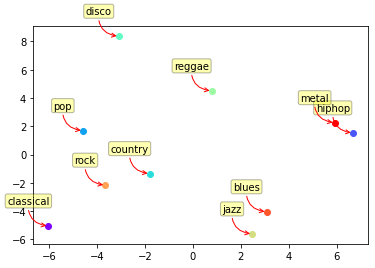

In [21]:
 fig, ax = plt.subplots()
for i in range(10):

    ax.scatter( mean_of_component[i][0] , mean_of_component[i][1] , color=colors[i] ,  )
        
    ax.annotate(f'{genre_dict[i]}', xy=(mean_of_component[i][0], mean_of_component[i][1] ), xytext=(-20,20), 
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='red'))

# conducting RSM using cosine_similarity

In [22]:
out_features.shape

(372, 1024)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
cos_similarity = cosine_similarity( out_features )

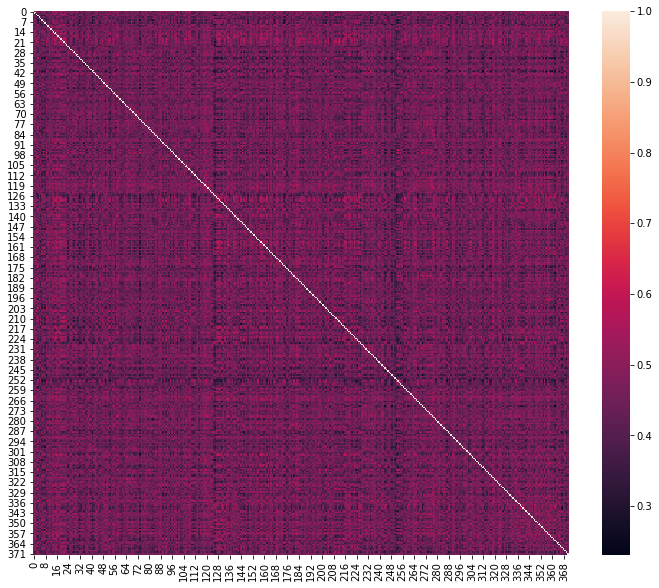

In [24]:
import seaborn
plt.figure( figsize=(12,10))
seaborn.heatmap( cos_similarity )

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


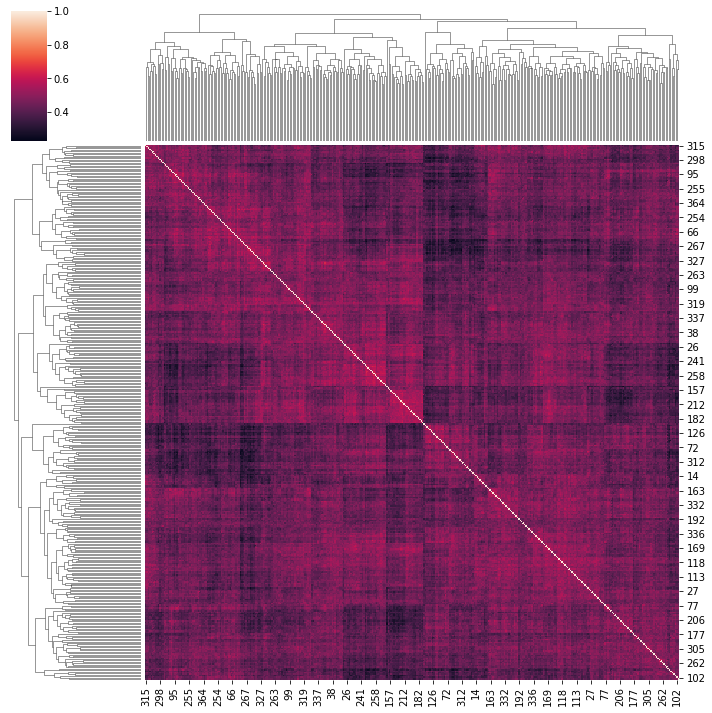

In [25]:
seaborn.clustermap(cos_similarity)

In [26]:
idx_targets= np.argsort( targets.squeeze() )

In [27]:
sorted_features= out_features[ idx_targets , :]

sorted_target= np.sort( targets.squeeze() )
sorted_genre =  np.array( [ genre_dict[i]for i in  sorted_target] ).squeeze()

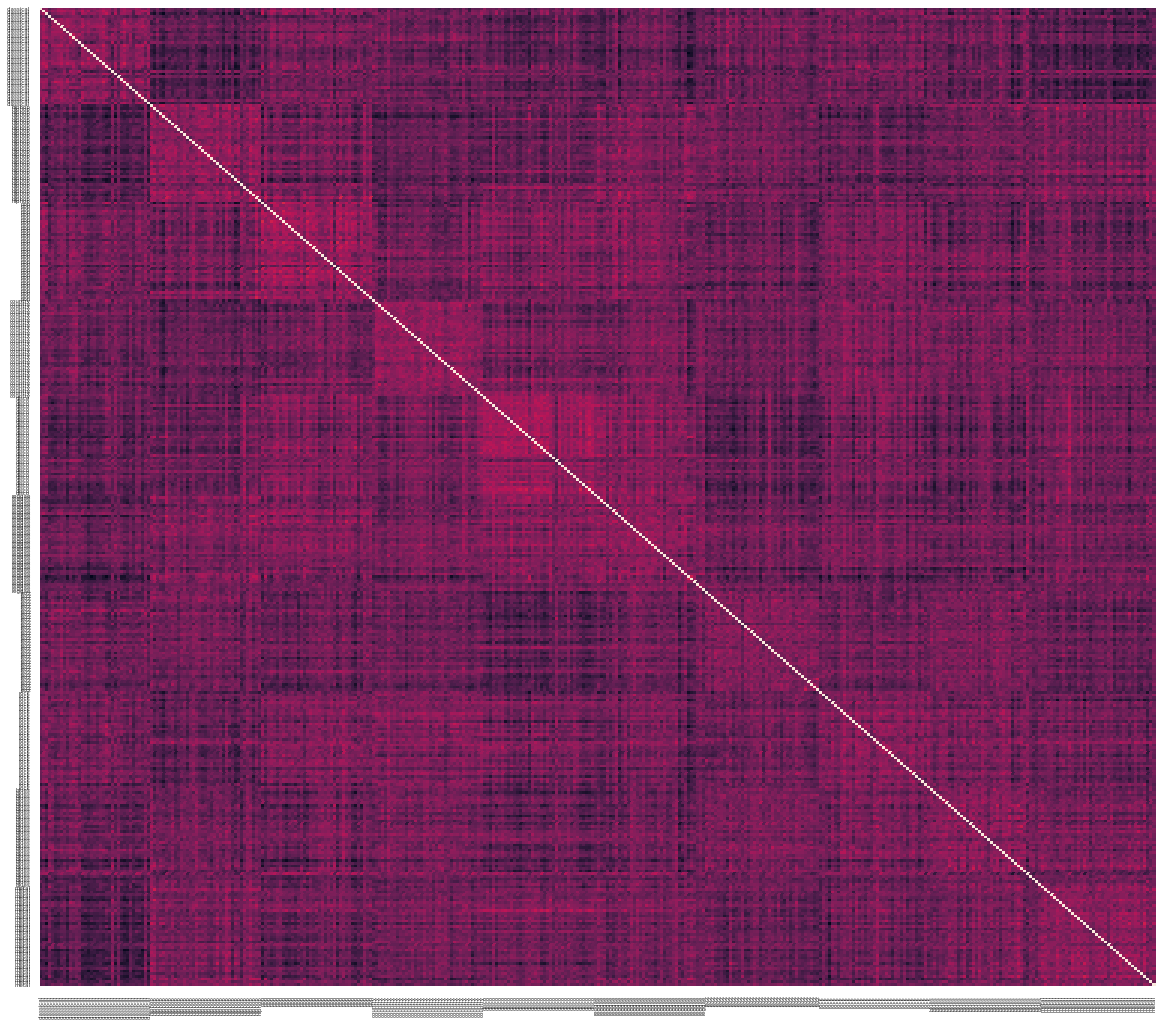

In [28]:
cos_sim_sorted= cosine_similarity( sorted_features )
plt.figure( figsize=(20,18))
seaborn.set(font_scale=0.5) 
seaborn.heatmap( cos_sim_sorted , xticklabels=sorted_genre, yticklabels=sorted_genre , cbar=False,)

# plotting heat maps for PCA with 10 components


In [29]:
from sklearn.decomposition import PCA
pca= PCA( 10  )
features_10 = pca.fit_transform( out_features )

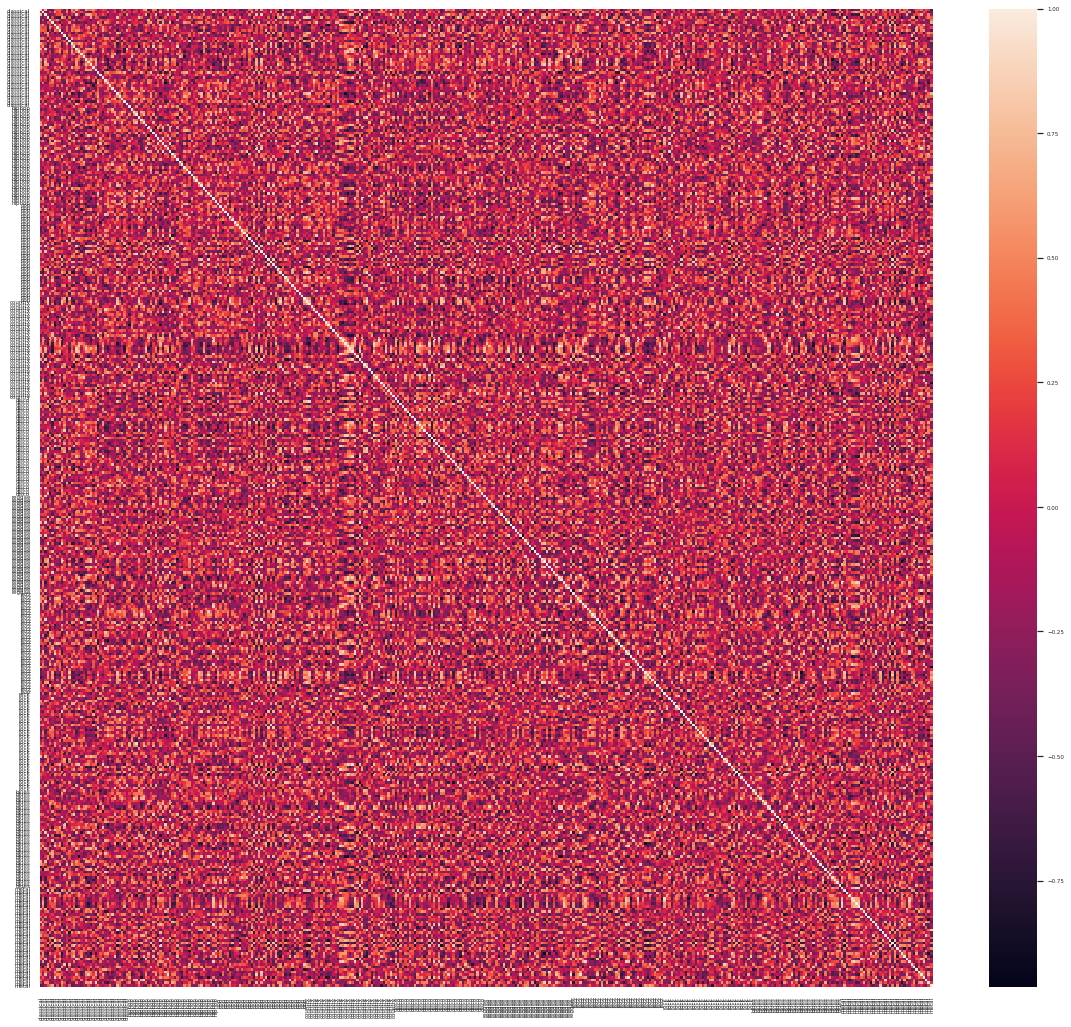

In [30]:
cos_sim_10f= cosine_similarity( features_10 )
plt.figure( figsize=(20,18))
seaborn.set(font_scale=0.5) 
seaborn.heatmap( cos_sim_10f , xticklabels=sorted_genre, yticklabels=sorted_genre )

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


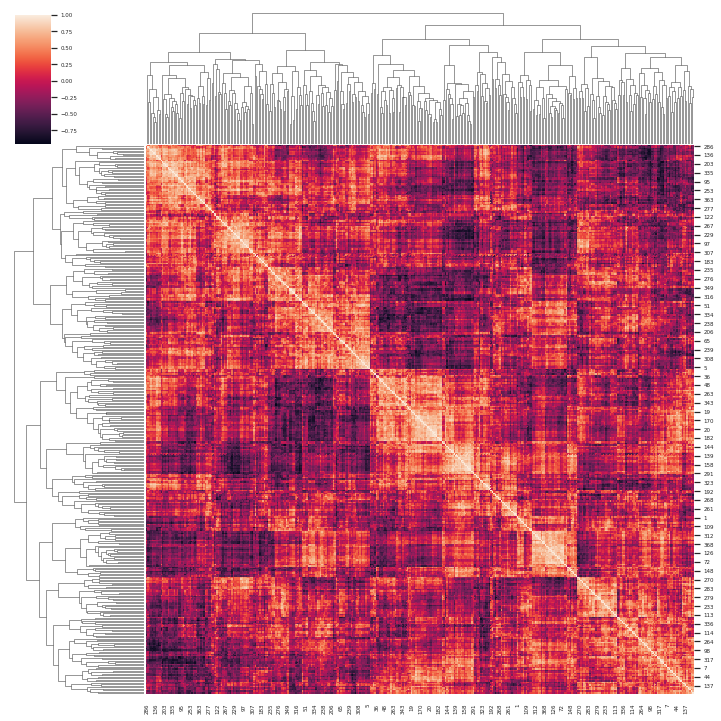

In [31]:
seaborn.clustermap(cos_sim_10f ,  )

# Visualizing the Model

In [37]:
!brew install graphviz
!pip install torchviz

/bin/bash: brew: command not found
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=e22a127c436612d644c770790fe7e91f87ee00ad5db4f172e4abe9f5277f7bfb
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


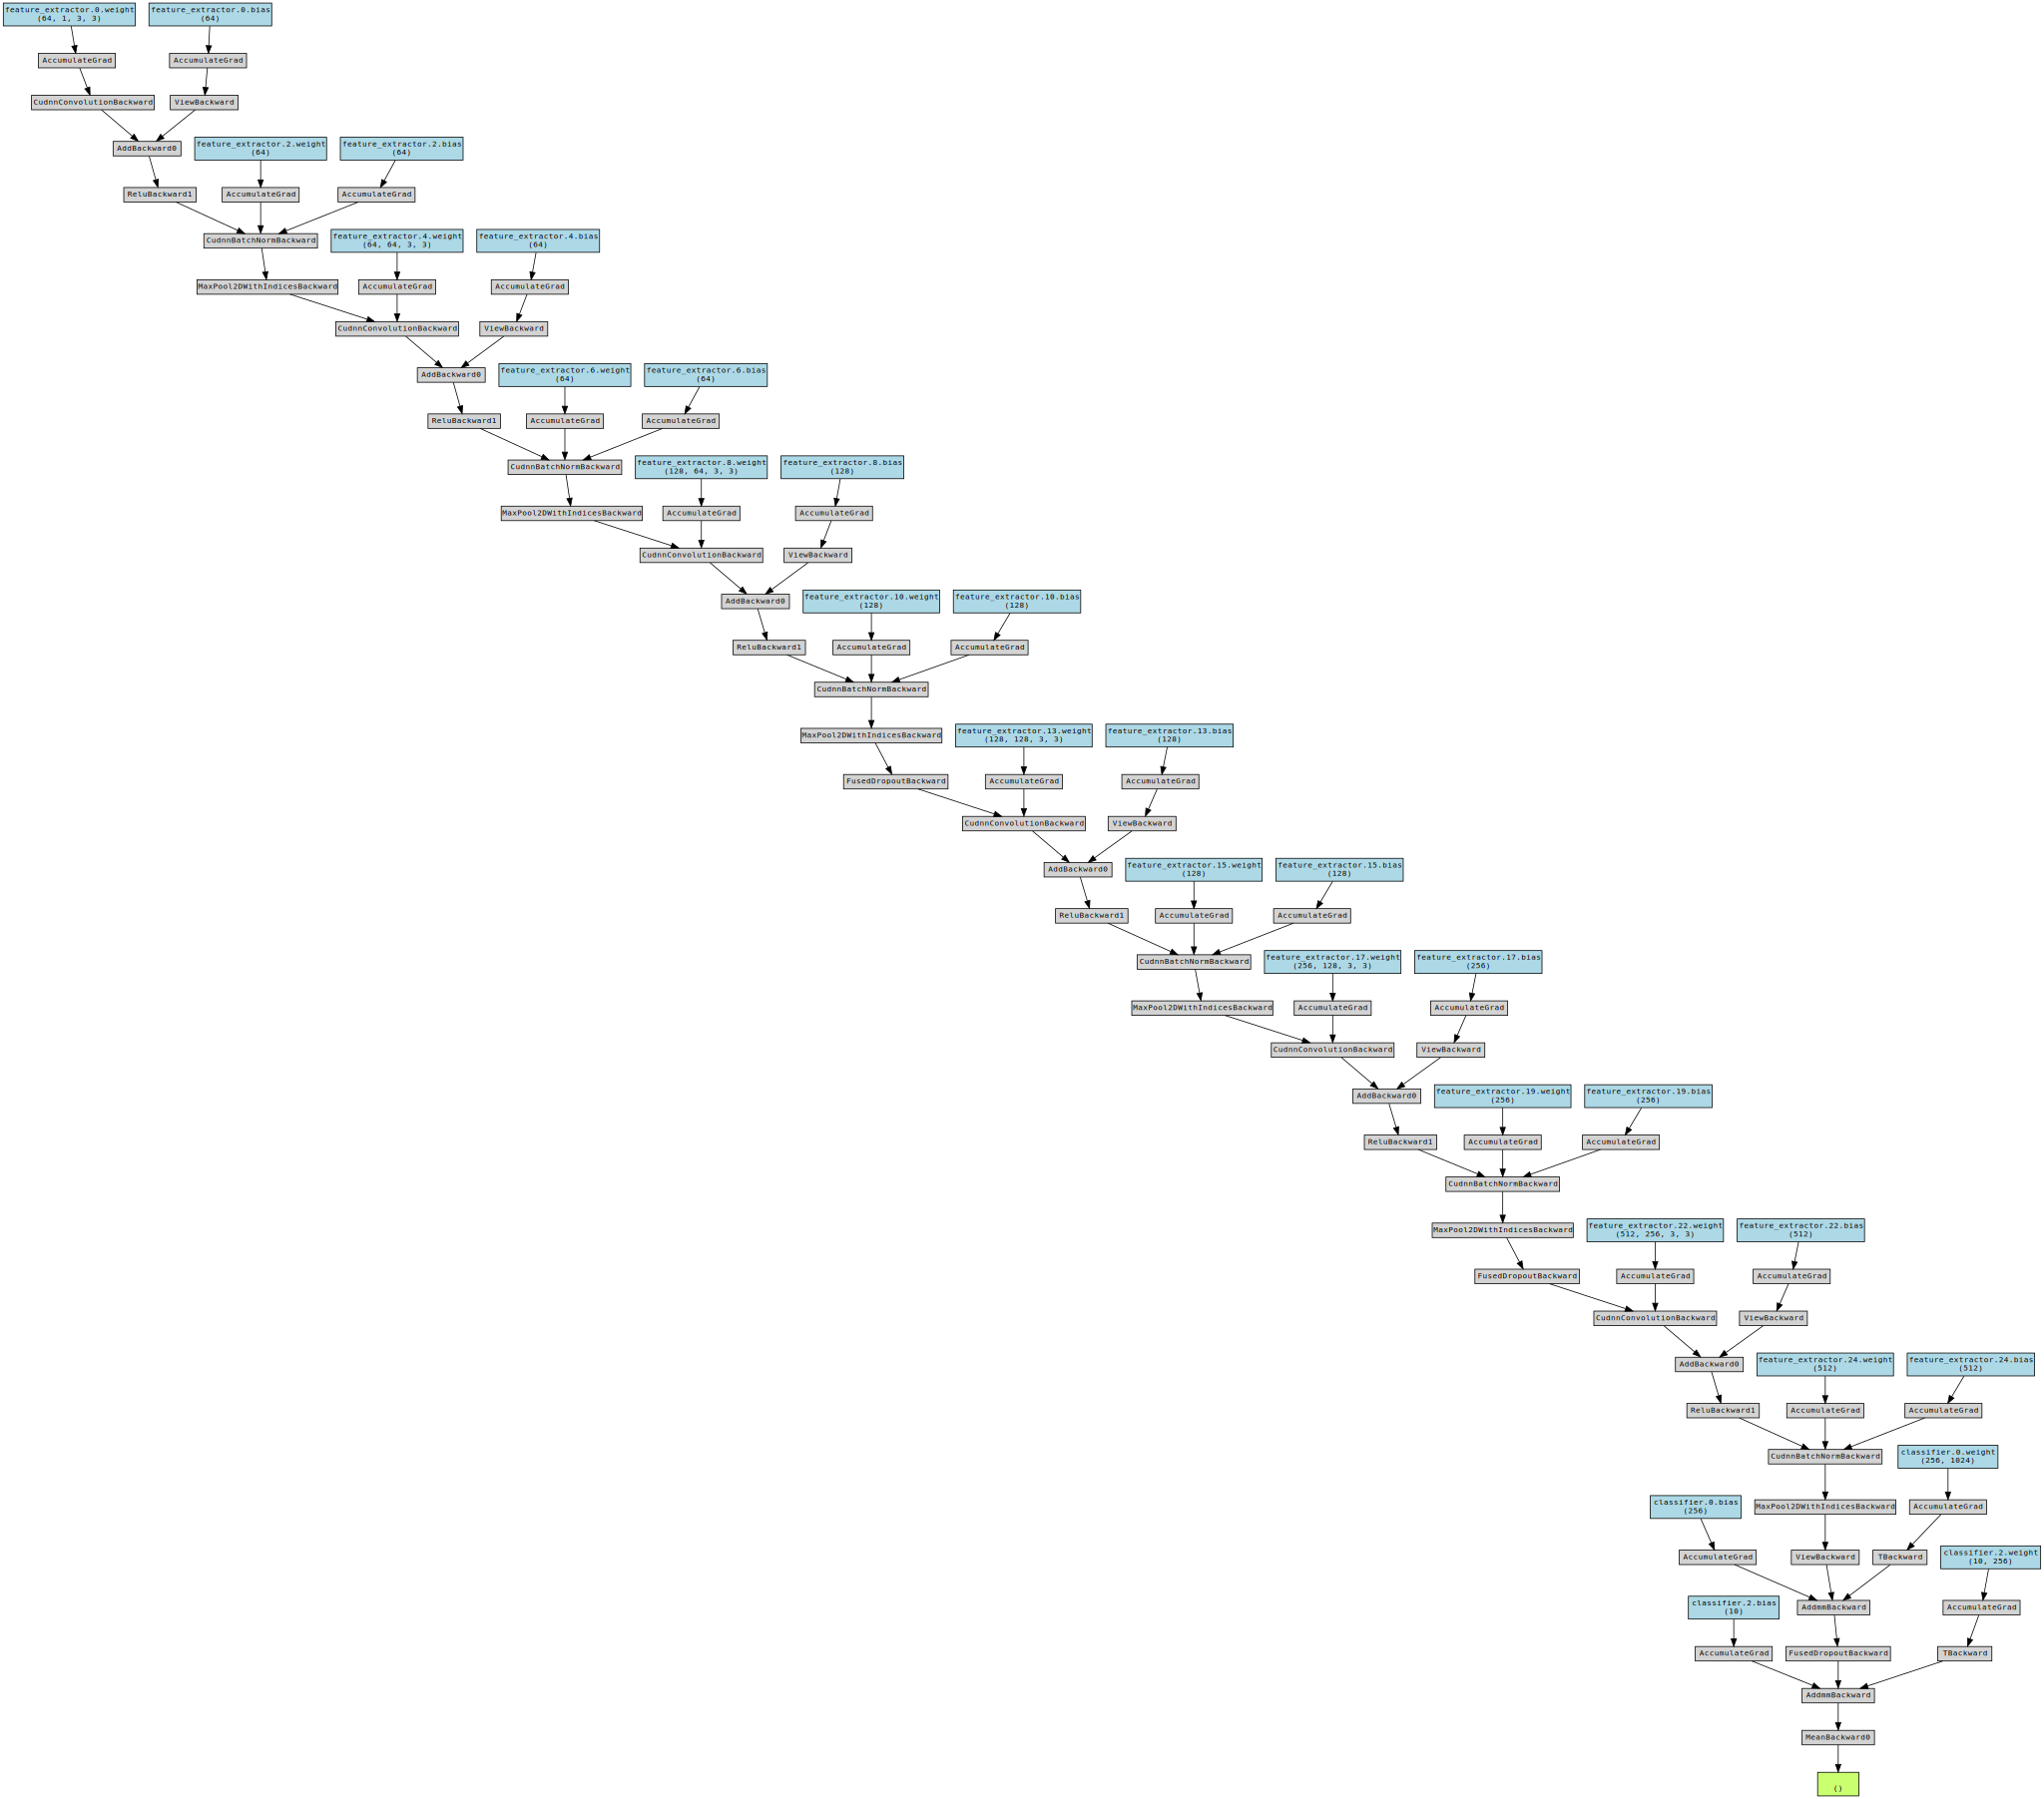

In [51]:
from torchviz import make_dot

x = torch.randn(1,1,140, 108).to(device)
y,_ = tmp_model(x)

make_dot(y.mean(), params=dict(tmp_model.named_parameters()) , show_attrs=False ,
         show_saved=False) #.render("rnn_torchviz", format="png")

In [60]:
print(tmp_model)

music_CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (14): ReL